In [1]:
!pip install numpy pennylane matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 45.8 MB/s eta 0:00:00


--- Starting Benchmark ---

[1/3] Calculating Classical Spectral Solution (Ground Truth)...
Classical spectral solution finished in 0.0055 seconds.

[2/3] Running Ideal Hybrid Solver...
--- Step 1/100 ---
--- Step 10/100 ---
--- Step 20/100 ---
--- Step 30/100 ---
--- Step 40/100 ---
--- Step 50/100 ---
--- Step 60/100 ---
--- Step 70/100 ---
--- Step 80/100 ---
--- Step 90/100 ---
--- Step 100/100 ---
Ideal hybrid solver finished in 0.7369 seconds.

[3/3] Running Noisy Hybrid Solver...
--- Step 1/100 ---
--- Step 10/100 ---
--- Step 20/100 ---
--- Step 30/100 ---
--- Step 40/100 ---
--- Step 50/100 ---
--- Step 60/100 ---
--- Step 70/100 ---
--- Step 80/100 ---
--- Step 90/100 ---
--- Step 100/100 ---
Noisy hybrid solver finished in 6.2844 seconds.

--- Benchmark Complete ---

--- Benchmark Summary ---
Parameters: N=64, T=0.01, dt=0.0001, nu=0.03, noise=0.001
--------------------------------------------------
Classical Spectral Solver Wall-Clock Time: 0.0055 s
Ideal Hybrid Solver Wall

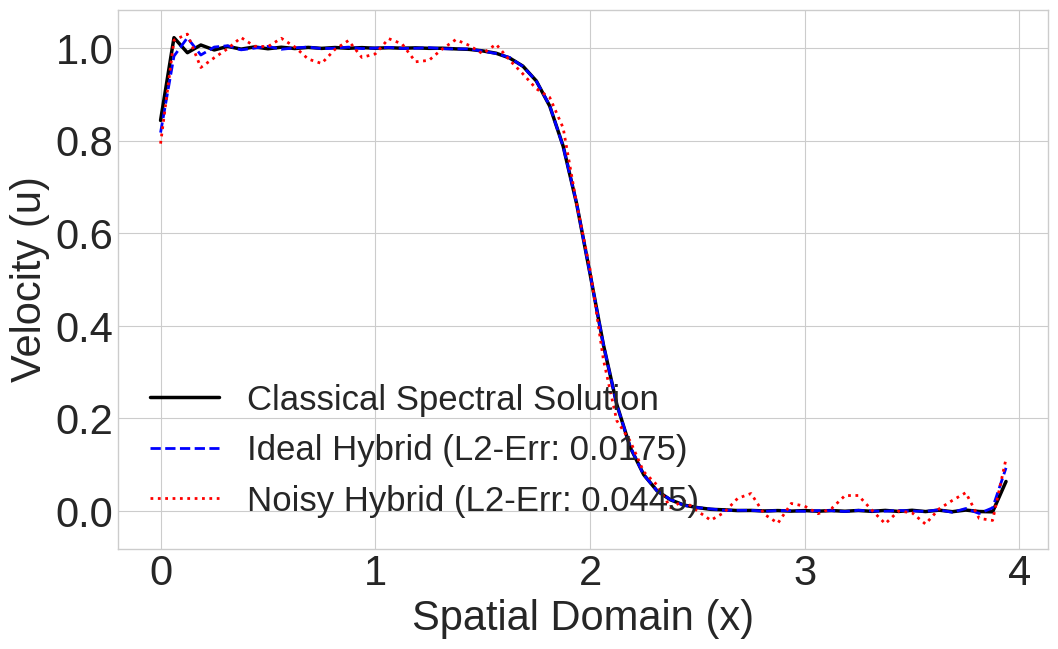

Circuit Diagram:
0: ─╭|Ψ⟩─╭U(M0)─┤  State
1: ─├|Ψ⟩─├U(M0)─┤  State
2: ─├|Ψ⟩─├U(M0)─┤  State
3: ─├|Ψ⟩─├U(M0)─┤  State
4: ─├|Ψ⟩─├U(M0)─┤  State
5: ─╰|Ψ⟩─╰U(M0)─┤  State

M0 = 
[0.99999992-4.10488999e-04j 0.99999825-1.87274841e-03j
 0.9999988 -1.54793595e-03j 0.99999843-1.77352659e-03j
 0.99999882-1.53369552e-03j 0.9999984 -1.78932665e-03j
 0.99999877-1.56627833e-03j 0.99999849-1.73772530e-03j
 0.9999987 -1.60966512e-03j 0.99999852-1.71820902e-03j
 0.9999987 -1.61305876e-03j 0.99999852-1.71806851e-03j
 0.99999869-1.62092496e-03j 0.99999855-1.70351761e-03j
 0.99999866-1.63546183e-03j 0.99999856-1.69513113e-03j
 0.99999866-1.63776012e-03j 0.99999856-1.69433140e-03j
 0.99999865-1.64119814e-03j 0.99999858-1.68657397e-03j
 0.99999864-1.64829211e-03j 0.99999859-1.67953265e-03j
 0.99999864-1.64706457e-03j 0.9999986 -1.67289129e-03j
 0.99999866-1.63826154e-03j 0.99999864-1.64755019e-03j
 0.99999871-1.60642386e-03j 0.99999876-1.57505219e-03j
 0.99999889-1.48834300e-03j 0.99999906-1.37333142e-03j
 

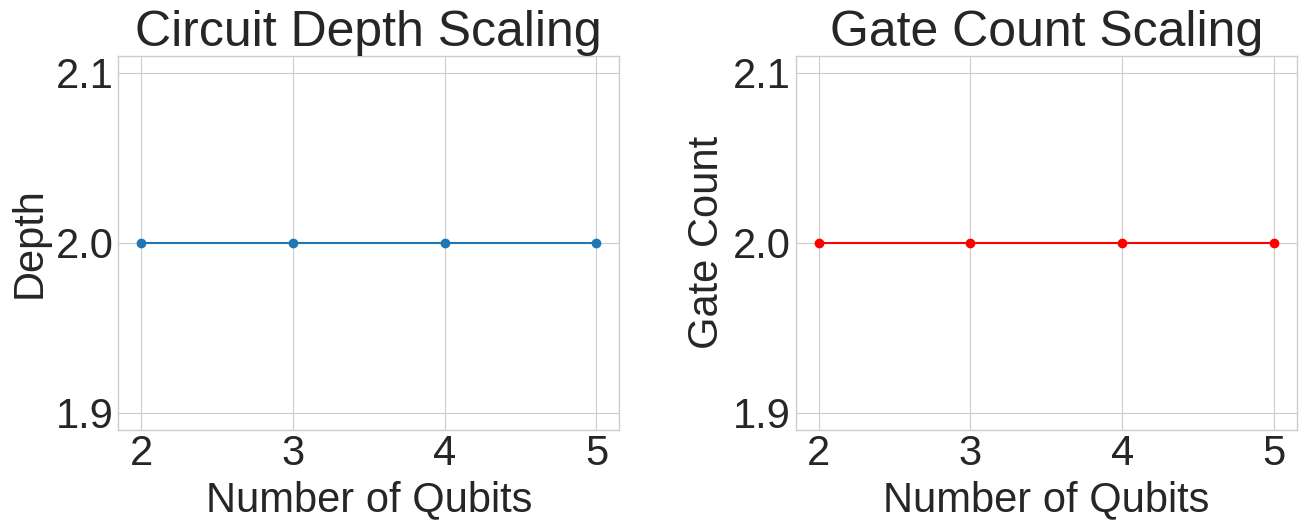

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pennylane as qml
from pennylane import numpy as pnp

# --- STABLE HYBRID SOLVER IMPLEMENTATION ---

class ClassicalProcessor:
    """
    Handles classical data processing, including the mappings between velocity and
    the quantum state, and the compression of the state into an MPS.
    """
    def __init__(self, N, L, nu):
        self.N = N
        self.L = L
        self.nu = nu
        self.x = np.linspace(0, L, N, endpoint=False)
        self.dx = self.L / self.N
        self.k = 2 * np.pi * np.fft.fftfreq(self.N, d=self.dx)

    def velocity_to_statevector(self, u_field):
        """Encodes the classical velocity field into the phase of a quantum state."""
        # The phase S is the integral of u, scaled by 1/nu for the HSE mapping.
        # We use spectral integration for accuracy and to enforce periodic boundaries.
        u_hat = np.fft.fft(u_field)
        k_inv = np.zeros_like(self.k, dtype=complex)
        k_inv[self.k != 0] = 1.0 / (1j * self.k[self.k != 0])
        phase_S_hat = (1.0 / self.nu) * u_hat * k_inv
        phase_S = np.fft.ifft(phase_S_hat).real

        amplitude = np.ones(self.N) / np.sqrt(self.N)
        return amplitude * np.exp(1j * phase_S)

    def statevector_to_velocity(self, statevector):
        """
        Extracts the classical velocity from the phase of the quantum state.
        This method avoids np.unwrap by calculating the phase gradient directly
        from the state vector's gradient (∇ψ), which is more numerically stable.
        The relationship is u = ν * ∇S, and for a constant-amplitude wavefunction,
        the phase gradient ∇S can be found via ∇S = -i * (∇ψ / ψ).
        """
        # Calculate the gradient of the state vector in Fourier space
        psi_hat = np.fft.fft(statevector)
        grad_psi_hat = 1j * self.k * psi_hat
        grad_psi = np.fft.ifft(grad_psi_hat)

        # This decoding process inherently produces a zero-mean velocity field.
        # The mean must be added back in the main solver loop.
        u = self.nu * (-1j * grad_psi / (statevector + 1e-14)).real

        return u

    def state_to_mps(self, state_vector, max_bond_dim=16):
        """Compresses a dense state vector into its MPS representation."""
        num_qubits = int(np.log2(len(state_vector)))
        psi = state_vector.reshape([2] * num_qubits)
        mps_tensors = []
        current_tensor = psi
        bond_dim_in = 1
        for i in range(num_qubits - 1):
            matrix_to_decompose = current_tensor.reshape(bond_dim_in * 2, -1)
            U, S, Vh = np.linalg.svd(matrix_to_decompose, full_matrices=False)
            bond_dim_out = min(len(S), max_bond_dim)
            U = U[:, :bond_dim_out]
            S = S[:bond_dim_out]
            Vh = Vh[:bond_dim_out, :]
            mps_tensor = U.reshape(bond_dim_in, 2, bond_dim_out)
            mps_tensors.append(mps_tensor)
            current_tensor = np.dot(np.diag(S), Vh)
            bond_dim_in = bond_dim_out
        last_tensor = current_tensor.reshape(bond_dim_in, 2, 1)
        mps_tensors.append(last_tensor)
        return mps_tensors

class PennyLaneQuantumCore:
    """
    Manages the quantum circuit execution for one time step of the HSE evolution.
    This version uses a simplified evolution based on a fully diagonal Hamiltonian.
    """
    def __init__(self, N, L, nu, dt, is_noisy=False, noise_strength=0.01):
        self.num_qubits = int(np.log2(N))
        self.N = N
        self.L = L
        self.nu = nu
        self.dt = dt
        self.wires = list(range(self.num_qubits))
        self.is_noisy = is_noisy
        self.noise_strength = noise_strength

        if is_noisy:
            self.device = qml.device("default.mixed", wires=self.num_qubits)
        else:
            self.device = qml.device("default.qubit", wires=self.num_qubits)


    def _apply_noise(self):
        """Helper function to apply depolarizing noise after each operation."""
        if self.is_noisy:
            for i in self.wires:
                qml.DepolarizingChannel(self.noise_strength, wires=i)

    def evolve_step(self, initial_state_vec, H_total_diag):
        """
        Evolves the state using the total diagonal Hamiltonian in the position basis.
        This version does not use QFT or Trotterization, as the entire
        Hamiltonian is diagonal in one basis, making the evolution exact.
        """
        # The evolution operator is U = exp(-i * H * dt)
        evolution_phases = -self.dt * H_total_diag
        evolution_unitary_diag = np.exp(1j * evolution_phases)

        @qml.qnode(self.device)
        def evolution_circuit():
            qml.StatePrep(initial_state_vec, wires=self.wires)
            self._apply_noise()
            qml.DiagonalQubitUnitary(evolution_unitary_diag, wires=self.wires)
            self._apply_noise()

            if self.is_noisy:
                 return qml.density_matrix(wires=self.wires)
            else:
                return qml.state()

        result = evolution_circuit()
        if self.is_noisy:
            eigenvalues, eigenvectors = np.linalg.eigh(result)
            return eigenvectors[:, -1]
        return result

class HybridQuantumSolver:
    """
    Solves the Burgers' equation using the full QTN-HSE hybrid workflow.
    This version uses the corrected, fully diagonal Hamiltonian.
    """
    def __init__(self, N, L, nu, T, dt, is_noisy=False, noise_strength=0.01, debug=False):
        self.N = N
        self.T = T
        self.dt = dt
        self.debug = debug
        self.x_grid = np.linspace(0, L, N, endpoint=False)
        self.classical_processor = ClassicalProcessor(N, L, nu)
        self.quantum_core = PennyLaneQuantumCore(N, L, nu, dt, is_noisy, noise_strength)
        self.u_history = []

    def solve(self, u0_func):
        # Initial step
        u = u0_func(self.x_grid)
        # --- BUG FIX: The mean of u is a conserved quantity. ---
        # We must track it classically as the phase-encoding is insensitive to it.
        u_mean = np.mean(u)

        self.u_history.append(u.copy())
        # The state vector only encodes the zero-mean part of the velocity.
        current_state_vec = self.classical_processor.velocity_to_statevector(u)

        num_steps = int(self.T / self.dt)
        print_every = max(1, num_steps // 10) if num_steps > 20 else 1

        for step_num in range(num_steps):
            if (step_num == 0) or ((step_num + 1) % print_every == 0):
                print(f"--- Step {step_num+1}/{num_steps} ---")

            mps_tensors = self.classical_processor.state_to_mps(current_state_vec, max_bond_dim=16)

            # 1. Get the zero-mean part of the velocity from the quantum state
            u_prime = self.classical_processor.statevector_to_velocity(current_state_vec)

            # 2. Reconstruct the full velocity by adding the conserved mean
            u_full = u_prime + u_mean

            # 3. Construct the Hamiltonian using the full velocity
            H_V_diag = (0.5 * u_full**2) / self.classical_processor.nu

            k = self.classical_processor.k
            u_hat = np.fft.fft(u_full)
            du_dx_hat = 1j * k * u_hat
            du_dx = np.fft.ifft(du_dx_hat).real
            H_K_diag = -du_dx

            H_total_diag = H_V_diag + H_K_diag

            # --- DEBUGGING ---
            if self.debug and ((step_num + 1) % print_every == 0):
                max_u = np.max(np.abs(u_full))
                max_H = np.max(np.abs(H_total_diag))
                print(f"    [Debug] Max|u|: {max_u:.4f}, Max|H|: {max_H:.4f}")

            # 4. Evolve the state (which represents the zero-mean part)
            current_state_vec = self.quantum_core.evolve_step(current_state_vec, H_total_diag)

            # 5. Store the full velocity (zero-mean part from state + conserved mean)
            final_u_prime = self.classical_processor.statevector_to_velocity(current_state_vec)
            self.u_history.append(final_u_prime + u_mean)

        return self.x_grid, self.u_history[-1]

class ClassicalSpectralSolver:
    """
    Solves the Burgers' equation using a classical spectral method (FFT).
    This serves as a more accurate benchmark for periodic boundary conditions
    than the Cole-Hopf analytical solution on a finite domain.
    """
    def __init__(self, N, L, nu):
        self.N = N
        self.L = L
        self.nu = nu
        self.k = 2 * np.pi * np.fft.fftfreq(N, d=L/N)
        self.x = np.linspace(0, L, N, endpoint=False)

    def solve(self, u0_func, T, dt):
        u = u0_func(self.x)
        u_hat = np.fft.fft(u)

        num_steps = int(T / dt)

        # Precompute the linear part's evolution operator (integrating factor)
        linear_op = np.exp(-self.nu * self.k**2 * dt)

        for _ in range(num_steps):
            # Calculate nonlinear term in real space
            u_sq = u**2
            # Transform to Fourier space and apply derivative
            u_sq_hat = np.fft.fft(u_sq)
            nonlinear_term_hat = -0.5 * 1j * self.k * u_sq_hat

            # Evolve one step using stiffly stable scheme
            u_hat = linear_op * (u_hat + dt * nonlinear_term_hat)

            # Transform back to real space for the next nonlinear calculation
            u = np.fft.ifft(u_hat).real

        return self.x, u

# --- BENCHMARKING FRAMEWORK ---

class BenchmarkRunner:
    """
    Orchestrates the comparison between the hybrid and classical solvers.
    """
    def __init__(self, N, L, nu, T, dt, noise_strength=0.01):
        self.N = N
        self.L = L
        self.nu = nu
        self.T = T
        self.dt = dt
        self.noise_strength = noise_strength
        self.results = {}

    def _calculate_l2_error(self, u_test, u_ref):
        """Calculates the L2 norm of the difference between two solutions."""
        if np.any(np.isnan(u_test)) or np.any(np.isnan(u_ref)):
            return np.nan
        dx = self.L / self.N
        return np.sqrt(np.sum((u_test - u_ref)**2) * dx)

    def run(self, u0_func, run_noisy_sim=True, debug_sim=False):
        print("--- Starting Benchmark ---")

        # 1. Classical Spectral Ground Truth
        print("\n[1/3] Calculating Classical Spectral Solution (Ground Truth)...")
        classical_solver = ClassicalSpectralSolver(self.N, self.L, self.nu)
        start_time = time.time()
        # The classical solver needs the same dt for a fair comparison
        x, u_classical = classical_solver.solve(u0_func, self.T, self.dt)
        classical_time = time.time() - start_time
        self.results['classical'] = {'u': u_classical, 'time': classical_time}
        print(f"Classical spectral solution finished in {classical_time:.4f} seconds.")

        # 2. Ideal (Noiseless) Hybrid Solver
        print("\n[2/3] Running Ideal Hybrid Solver...")
        ideal_quantum_solver = HybridQuantumSolver(self.N, self.L, self.nu, self.T, self.dt, is_noisy=False, debug=debug_sim)
        start_time = time.time()
        _, u_ideal_quantum = ideal_quantum_solver.solve(u0_func)
        ideal_quantum_time = time.time() - start_time
        ideal_error = self._calculate_l2_error(u_ideal_quantum, u_classical)
        self.results['ideal_quantum'] = {'u': u_ideal_quantum, 'time': ideal_quantum_time, 'l2_error': ideal_error}
        print(f"Ideal hybrid solver finished in {ideal_quantum_time:.4f} seconds.")

        # 3. Noisy Hybrid Solver (Conditional)
        if run_noisy_sim:
            print("\n[3/3] Running Noisy Hybrid Solver...")
            noisy_quantum_solver = HybridQuantumSolver(self.N, self.L, self.nu, self.T, self.dt, is_noisy=True, noise_strength=self.noise_strength, debug=debug_sim)
            start_time = time.time()
            _, u_noisy_quantum = noisy_quantum_solver.solve(u0_func)
            noisy_quantum_time = time.time() - start_time
            noisy_error = self._calculate_l2_error(u_noisy_quantum, u_classical)
            self.results['noisy_quantum'] = {'u': u_noisy_quantum, 'time': noisy_quantum_time, 'l2_error': noisy_error}
            print(f"Noisy hybrid solver finished in {noisy_quantum_time:.4f} seconds.")

        print("\n--- Benchmark Complete ---")
        self.print_summary()
        self.plot_results()

    def print_summary(self):
        print("\n--- Benchmark Summary ---")
        print(f"Parameters: N={self.N}, T={self.T}, dt={self.dt}, nu={self.nu}, noise={self.noise_strength if 'noisy_quantum' in self.results else 'N/A'}")
        print("-" * 50)
        print(f"Classical Spectral Solver Wall-Clock Time: {self.results['classical']['time']:.4f} s")
        print(f"Ideal Hybrid Solver Wall-Clock Time: {self.results['ideal_quantum']['time']:.4f} s")
        if 'noisy_quantum' in self.results:
            print(f"Noisy Hybrid Solver Wall-Clock Time: {self.results['noisy_quantum']['time']:.4f} s")
        print("-" * 50)
        print(f"Ideal Hybrid Solver L2-Error vs Classical: {self.results['ideal_quantum']['l2_error']:.6f}")
        if 'noisy_quantum' in self.results:
            print(f"Noisy Hybrid Solver L2-Error vs Classical: {self.results['noisy_quantum']['l2_error']:.6f}")
        print("-" * 50)

    def plot_results(self):
        x = np.linspace(0, self.L, self.N, endpoint=False)
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(12, 7))

        ax.plot(x, self.results['classical']['u'], 'k-', label='Classical Spectral Solution', linewidth=2.5)
        ax.plot(x, self.results['ideal_quantum']['u'], 'b--', label=f"Ideal Hybrid (L2-Err: {self.results['ideal_quantum']['l2_error']:.4f})", linewidth=2)
        if 'noisy_quantum' in self.results:
            ax.plot(x, self.results['noisy_quantum']['u'], 'r:', label=f"Noisy Hybrid (L2-Err: {self.results['noisy_quantum']['l2_error']:.4f})", linewidth=2)

        ax.set_xlabel("Spatial Domain (x)")
        ax.set_ylabel("Velocity (u)")
        ax.legend(loc='lower left',fontsize='small')
        ax.grid(True)
        plt.show()

# --- RESOURCE AND SCALABILITY ANALYSIS ---

class Analysis:
    def __init__(self, N, L, nu, dt):
        self.N = N
        self.num_qubits = int(np.log2(N))
        self.L = L
        self.nu = nu
        self.dt = dt
        self.device = qml.device("default.qubit", wires=self.num_qubits)

    def get_resource_estimates(self, u0_func):
        """Provides resource estimates for a single time step."""
        u = u0_func(np.linspace(0, self.L, self.N, endpoint=False))
        u_mean = np.mean(u)
        classical_processor = ClassicalProcessor(self.N, self.L, self.nu)
        initial_state_vec = classical_processor.velocity_to_statevector(u)

        u_prime = classical_processor.statevector_to_velocity(initial_state_vec)
        u_full = u_prime + u_mean

        H_V_diag = (0.5 * u_full**2) / self.nu
        k = classical_processor.k
        du_dx = np.fft.ifft(1j * k * np.fft.fft(u_full)).real
        H_K_diag = -du_dx
        H_total_diag = H_V_diag + H_K_diag
        evolution_phases = -self.dt * H_total_diag
        evolution_unitary_diag = np.exp(1j * evolution_phases)

        @qml.qnode(self.device)
        def circuit():
            qml.StatePrep(initial_state_vec, wires=range(self.num_qubits))
            qml.DiagonalQubitUnitary(evolution_unitary_diag, wires=range(self.num_qubits))
            return qml.state()

        # Draw the circuit to visualize
        print("Circuit Diagram:")
        print(qml.draw(circuit)())

        # Get resource estimates
        resources = qml.specs(circuit)()

        print("\n--- Resource Analysis ---")
        print(f"Grid Size (N): {self.N}")
        print(f"Number of Qubits: {self.num_qubits}")
        print("\nCircuit Specifications:")
        for key, val in resources.items():
            print(f"  {key}: {val}")

        return resources

    def scalability_study(self, u0_func, N_values):
        """Shows how resources scale with grid size."""
        print("\n--- Scalability Study ---")
        qubits = []
        depths = []
        gate_counts = []

        for n_val in N_values:
            num_q = int(np.log2(n_val))
            print(f"\nAnalyzing for N = {n_val} ({num_q} qubits)...")

            # Re-initialize for each N
            analysis_temp = Analysis(n_val, self.L, self.nu, self.dt)
            resources_specs = analysis_temp.get_resource_estimates(u0_func)

            # Correctly access the nested resources dictionary
            resources = resources_specs['resources']

            qubits.append(num_q)
            depths.append(resources.depth)

            # Summing up gate counts
            total_gates = sum(resources.gate_sizes.values())
            gate_counts.append(total_gates)


        # Plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        ax1.plot(qubits, depths, 'o-', label='Circuit Depth')
        ax1.set_xlabel("Number of Qubits")
        ax1.set_ylabel("Depth")
        ax1.set_title("Circuit Depth Scaling")
        ax1.grid(True)

        ax2.plot(qubits, gate_counts, 'o-', label='Total Gate Count', color='r')
        ax2.set_xlabel("Number of Qubits")
        ax2.set_ylabel("Gate Count")
        ax2.set_title("Gate Count Scaling")
        ax2.grid(True)

        plt.tight_layout()
        plt.show()


if __name__ == '__main__':
    # --- Simulation Parameters (Reverted to original values) ---
    N = 64         # Grid points (6 qubits).
    L = 4.0        # Domain length
    nu = 0.03      # Viscosity
    dt = 1e-4      # Time step (smaller for stability)
    T = 100*dt     # Total simulation time
    plt.rcParams['font.size'] = 30

    # --- Initial Condition: Smoothed "Shock Tube" ---
    def shock_tube_initial_condition(x):
        return 0.5 * (1 - np.tanh((x - L/2) / (L/20)))

    # --- Run the Benchmark ---
    # The noise_strength simulates the depolarizing error probability after each gate.
    # Set debug_sim=True to see intermediate values printed out.
    benchmark = BenchmarkRunner(N=N, L=L, nu=nu, T=T, dt=dt, noise_strength=0.001)
    benchmark.run(shock_tube_initial_condition, run_noisy_sim=True, debug_sim=False)

    # --- Analysis ---
    analysis = Analysis(N, L, nu, dt)

    # 1. Resource Estimates
    analysis.get_resource_estimates(shock_tube_initial_condition)

    # 2. Scalability Study
    # N_values_for_scaling = [4, 8, 16, 32] # 2, 3, 4, 5 qubits
    # analysis.scalability_study(shock_tube_initial_condition, N_values_for_scaling)
